In [1]:
import os
import re
import csv
import string
import pandas as pd
import numpy as np
import statistics
import itertools
from PIL import Image
import time
from io import StringIO
from skimage import io
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Lambda, Resize, Compose, ToPILImage, Normalize, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

def seed_everything(seed=0):
    np.random.seed(seed)         # NumPy
    torch.manual_seed(seed)      # PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # GPU에서 PyTorch

seed = 2024
seed_everything(seed)

### Setup

In [2]:
os.chdir("C:/Users/haley/Desktop/Submit_07/시드니/COMP5329S1A2Dataset")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


# EDA

In [4]:
images = sorted(os.listdir("./data"))
FILENAME = 'train.csv'

# Read the CSV file, applying a regex to correct improperly escaped quotes
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
train_img_list = train["ImageID"].values.tolist()

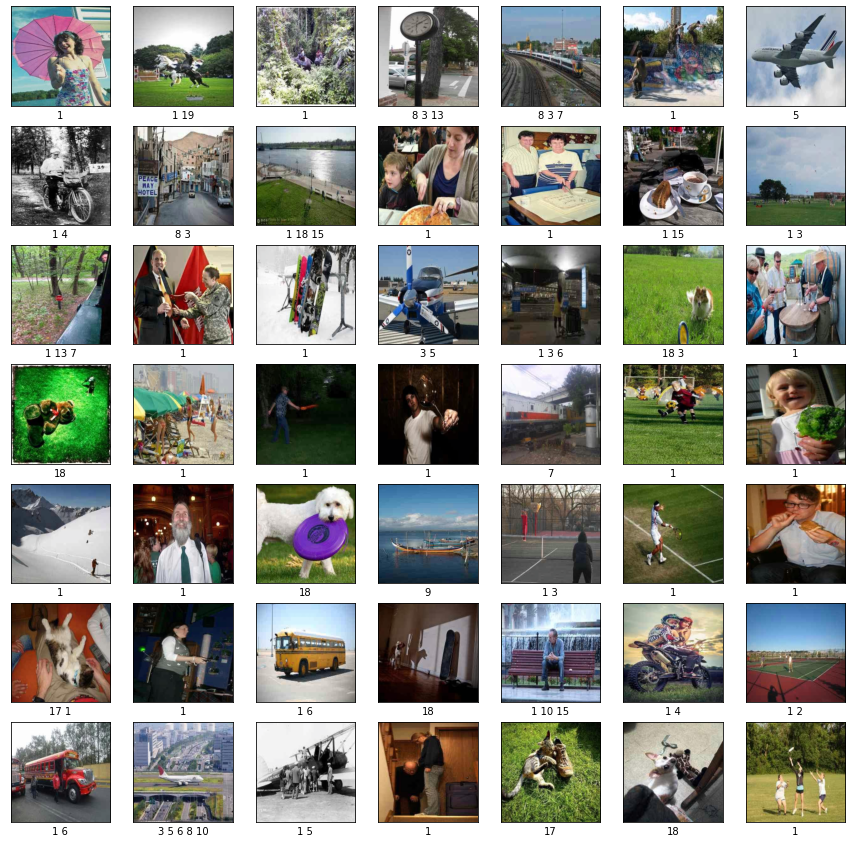

In [5]:
for j in range(0,1):
    plt.figure(figsize=(15,15))
    for i in range(49*j,49*(j+1)):
        # Construct the path to the image file
        image_path = "./data/" + train_img_list[i]

        # Open the image file, convert to RGB
        image = Image.open(image_path).convert('RGB')

        # Define transformations: Resize, convert to tensor, and normalize
        transform = Compose([
            Resize((299, 299)),  # Resize the image
            ToTensor(),          # Convert the image to a PyTorch tensor
            Normalize(mean=[0.4638, 0.4490, 0.4222], 
                                 std=[0.2725, 0.2698, 0.2849])   # Normalize using ImageNet standards
        ])

        # Apply the transformations
        image_tensor = transform(image)


        # Add a batch dimension
        image_tensor = image_tensor.unsqueeze(0)  
        

        # Convert the PyTorch tensor to a NumPy array and adjust the channel order from (C, H, W) to (H, W, C)
        image_numpy = image_tensor.squeeze().permute(1, 2, 0).numpy()

        # The normalization of the image needs to be undone to display it correctly
        mean=[0.4638, 0.4490, 0.4222];std=[0.2725, 0.2698, 0.2849]
        image_numpy = std * image_numpy + mean
        image_numpy = np.clip(image_numpy, 0, 1)  # Clip the values to be between 0 and 1

        # Display the image
        plt.subplot(7,7,i+1 - 49*j)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_numpy)
        plt.xlabel(train["Labels"][i])
        

    plt.show()

# Data Read & Check

In [6]:
class LoadDatasets(Dataset):

    def __init__(self, dataset_file, is_training=True, label_transform=None, image_transform=None):
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.is_training = is_training

        with open(dataset_file) as file:
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
            self.dataframe = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # Construct the path to the image file and load it
        image_file_path = os.path.join("./data", self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')])

        image = io.imread(image_file_path)
        # Fetch the image ID and description from the DataFrame
        image_id = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')]
        description = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Caption')]

        if self.is_training:
            # For training data, parse labels and apply transformations if any
            category_labels = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Labels')]
            category_labels = category_labels.split(' ')
            category_labels = [int(x) for x in category_labels]

            if self.label_transform:
                category_labels = self.label_transform(category_labels)
            if self.image_transform:
                image = self.image_transform(image)

            data_tuple = (image, category_labels, image_id, description)

        else:
            # For testing, no labels are provided, only apply image transformations
            if self.image_transform:
                image = self.image_transform(image)
            data_tuple = (image, image_id, description)

        return data_tuple

In [7]:
num_categories = 19
batch_size_setting = 1

# Define image transformations
data_augmentations = Compose([
    ToTensor(),
])

# Initialize dataset and DataLoader for training
training_data = LoadDatasets(dataset_file="train.csv",
                             is_training=True,
                             label_transform=Lambda(lambda y: torch.zeros(num_categories, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                             image_transform=data_augmentations)

training_loader = DataLoader(training_data, batch_size=batch_size_setting, shuffle=False)


In [8]:
def calculate_image_stats(loader):
    channel_sum, channel_sumsq, total_batches = 0, 0, 0

    for step, (imgs, _, _, _) in enumerate(loader):
        channel_sum += torch.mean(imgs, dim=[0, 2, 3])
        channel_sumsq += torch.mean(imgs ** 2, dim=[0, 2, 3])
        total_batches += 1

    mean_channels = channel_sum / total_batches
    std_channels = (channel_sumsq / total_batches - mean_channels ** 2) ** 0.5

    return mean_channels, std_channels

mean_vals, std_vals = calculate_image_stats(training_loader)

In [9]:
print(mean_vals,std_vals)

tensor([0.4638, 0.4490, 0.4222]) tensor([0.2725, 0.2698, 0.2849])


In [10]:
def extract_image_dimensions(loader):
    height_list, width_list = [], []

    for step, (img, _, _, _) in enumerate(loader):
        height_list.append(img.size()[2])
        width_list.append(img.size()[3])

    return height_list, width_list

height_list, width_list = extract_image_dimensions(training_loader)

# Printing basic statistics about the image sizes
print(f'Median height: {statistics.median(height_list)}')
print(f'Mean height: {statistics.mean(height_list)}')
print(f'Median width: {statistics.median(width_list)}')
print(f'Mean width: {statistics.mean(width_list)}')

Median height: 240.0
Mean height: 240.5502066942259
Median width: 320.0
Mean width: 289.9553940525403


## Creating Train/Test/Validation Datasets and Encoding/Decoding

In [11]:
num_categories = 19
batch_size_setting = 50

proportion_train_val = 0.8
random_seed = 2024


image_preprocessing = Compose([
    ToTensor(),
    Normalize(mean=[0.4638, 0.4490, 0.4222], std=[0.2725, 0.2698, 0.2849]),
    Resize((299, 299)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomCrop(224)  # Standard crop size
])

# Preparing the main dataset with training and validation splits
full_dataset = LoadDatasets(dataset_file="train.csv",
                            is_training=True,
                            label_transform=Lambda(lambda y: torch.zeros(num_categories, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                            image_transform=image_preprocessing)

train_set_size = int(proportion_train_val * len(full_dataset))
validation_set_size = len(full_dataset) - train_set_size
train_dataset, validation_dataset = random_split(full_dataset, [train_set_size, validation_set_size], generator=torch.Generator().manual_seed(random_seed))

# Setup for the testing dataset without labels
test_dataset = LoadDatasets(dataset_file="test.csv", is_training=False, image_transform=image_preprocessing)
main_loader = DataLoader(full_dataset, batch_size = batch_size_setting, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size_setting, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [12]:
def encode_model_outputs(output_tensor, activation_threshold):
    thresholded_outputs = []
    for item in range(len(output_tensor)):
        encoded = np.zeros(19).tolist()
        for j in range(len(output_tensor[i][0])):
            encoded[j] = 1 if output_tensor[i][0][j].item() >= activation_threshold else 0
        thresholded_outputs.append(encoded)
    return thresholded_outputs

def decode_model_labels(category_labels, activation_threshold):
    decoded_labels = []
    for i in range(len(category_labels)):
        label = []
        for j in range(len(category_labels[i][0])):
            if category_labels[i][0][j].item() >= activation_threshold:
                label.append(j + 1)
        decoded_labels.append(label)
    return decoded_labels

# Model Training and Evaluation

In [14]:
def training_cycle(data_loader, validation_loader, neural_model, criterion, optimizer, eval_threshold=None, include_captions=False, activation='ReLU'):
    batch_losses_train = []
    batch_losses_val = []
    f1_scores_validation = []

    total_size = len(data_loader.dataset)
    neural_model.train()

    for batch_num, (images, labels, _, captions) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)

        if include_captions:
            encoded_captions = encode_captions(captions)
            predictions = neural_model(images, encoded_captions)
        else:
            predictions = neural_model(images)

        loss = criterion(predictions, labels.float()) if type(neural_model) != torchvision.models.inception.Inception3 else criterion(predictions.logits, labels.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_num % evaluation_frequency == 0:  # evaluation_frequency is replaced by 100 for simplicity
            batch_losses_train.append(loss.item())
            train_loss, current = loss.item(), batch_num * len(images)
            print(f'Current observation is {current}')
            
            # setting test_loss to dummy value
            test_loss = 0
            test_f1 = 0
            
            if eval_threshold is not None:
                sig = nn.Sigmoid()
                pred_list = []
                true_list = []
                # Switch to eval mode for evaluating test set
                neural_model.eval()
                with torch.no_grad():
                    for images, labels, _, captions in validation_loader:
                        images, labels = images.to(device), labels.to(device)
                        true_list.append(labels.tolist()[0])
                        
                        if include_captions:
                            captions_encoded = encode_captions(captions)
                            predictions = neural_model.forward(images, captions_encoded,activation = activation)
                        else:
                            predictions = neural_model.forward(images, activation = activation)
                        
                        sig_pred = sig(predictions.cpu())
                        pred_list.append(sig_pred)
                        test_loss = criterion(predictions, labels.type(torch.float))
                        
                encoded_val_outputs = encode_model_outputs(pred_list, eval_threshold)
                
                test_f1 = f1_score(y_true = true_list, y_pred = encoded_val_outputs, average = "weighted", zero_division = 0)

                batch_losses_val.append(test_loss.item())
                f1_scores_validation.append(test_f1)
                
                neural_model.train()
            
            if eval_threshold is None:
                print(f"train loss: {train_loss:>7f}  [{current:>5d}/{total_size:>5d}]")
            else:
                print(f"train loss: {train_loss:>7f}  [{current:>5d}/{total_size:>5d}], validation loss: {test_loss:>7f}, validation mean f1: {test_f1:>7f}")
            
                
                
    return batch_losses_train, batch_losses_val, f1_scores_validation

### Output to submission function

In [15]:
def submit_predictions(test_loader, neural_model, activation_threshold, include_captions = False, activation = 'ReLU'):

    # Sigmoid activation for converting logits to probabilities
    sig = torch.nn.Sigmoid()
    
    
    all_predictions = []
    text_predictions = []
    image_ids = test_loader.dataset.dataframe['ImageID']

    headers = ['ImageID', 'Labels']
    all_labels = [headers]

    neural_model.eval() # Set model to evaluation mode
    with torch.no_grad():
        for image_data, _, captions in test_loader:
            image_data = image_data.to(device)

            if include_captions:
                word_encoding_array = encode_captions(captions)
                output_tensor = neural_model.forward(image_data, word_encoding_array, activation = activation).cpu()
            else:
                output_tensor = neural_model.forward(image_data, activation = activation).cpu()

            output_tensor = sig(output_tensor)
            all_predictions.append(output_tensor)
    # Decode predictions to readable labels
    decoded_predictions = decode_model_labels(all_predictions, activation_threshold)
    for i in range(len(decoded_predictions)):
        single_text = [image_ids[i], " ".join(map(str, decoded_predictions[i]))]
        text_predictions.append(" ".join(map(str, decoded_predictions[i])))
        
        all_labels.append(single_text)
        
    final_output = all_labels
    output_dataframe = pd.DataFrame({"ImageID": test_loader.dataset.dataframe['ImageID'], "Labels": text_predictions})
    

    return final_output, output_dataframe



### Caption Encoding

In [16]:
# Alphabet to index mapping for caption encoding
alphabet_indexes = {'1': string.ascii_lowercase, '2': string.ascii_lowercase, '3': string.ascii_lowercase}
alphabet_to_index = {}
index_counter = 0

# Generate a unique index for every possible trigram combination of lowercase ASCII letters
for combo in itertools.product(*[alphabet_indexes[k] for k in sorted(alphabet_indexes.keys())]):
    combination = ''.join(combo)
    alphabet_to_index[combination] = index_counter
    index_counter += 1

def encode_captions(captions):
    # Encodes captions into numerical arrays using trigram hashing
    caption_array  = np.zeros((len(captions), len(alphabet_to_index)))

    for caption_index, single_caption in enumerate(captions):
        filtered_text = [char for char in single_caption.lower() if char in string.ascii_lowercase]

        for position in range(len(filtered_text) - 2):
            tri_combination = ''.join(filtered_text[position:position + 3])
            if tri_combination in alphabet_to_index:
                caption_array[caption_index][alphabet_to_index[tri_combination]] += 1

    tensor_caption_array = torch.from_numpy(caption_array).to(device)

    return tensor_caption_array



# Model Architecture

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class CNN_LSTM_Transformer(nn.Module):
    def __init__(self,dropout=0.7, enable_feature_maps=False, include_captions=True):
        super(CNN_LSTM_Transformer, self).__init__()
        self.enable_feature_maps = enable_feature_maps
        self.include_captions = include_captions
        
        # CNN layers
        self.cnn_layer1 = nn.Conv2d(3, 128, 3, stride=1, padding=1)
        self.cnn_layer2 = nn.Conv2d(128, 64, 3, stride=1, padding=1)
        self.cnn_layer3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True)
        
        # Transformer layers
        encoder_layer = TransformerEncoderLayer(d_model=128, nhead=4)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        
        # Fully connected layers
        self.dense1 = nn.Linear(17704, 1024)
        self.dense2 = nn.Linear(1024, num_categories)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor, caption_inputs=None, activation = 'ReLU'):
        feature_maps = []

        # CNN layers
        if activation == 'ReLU':
            x = self.cnn_layer1(x)
            feature_maps.append(x)
            x = F.max_pool2d(x, 2)
            x = F.relu(x)

            x = self.cnn_layer2(x)
            feature_maps.append(x)
            x = F.max_pool2d(x, 2)
            x = F.relu(x)

            x = self.cnn_layer3(x)
            feature_maps.append(x)
            x = F.max_pool2d(x, 2)
            x = F.relu(x)
        
        if activation == 'GeLU':
            x = self.cnn_layer1(x)
            feature_maps.append(x)
            x = F.max_pool2d(x, 2)
            x = F.gelu(x)

            x = self.cnn_layer2(x)
            feature_maps.append(x)
            x = F.max_pool2d(x, 2)
            x = F.gelu(x)

            x = self.cnn_layer3(x)
            feature_maps.append(x)
            x = F.max_pool2d(x, 2)
            x = F.gelu(x)        
        
        

        # Reshaping for LSTM
        batch_size, channels, height, width = x.shape
        lstm_input = x.view(batch_size, -1, channels)
        
        # LSTM processing
        lstm_output, _ = self.lstm(lstm_input)
        lstm_output = lstm_output[:, -1, :]  # Using the last output

        # Transformer processing
        transformer_output = self.transformer_encoder(lstm_output.unsqueeze(1)).squeeze(1)

        if caption_inputs is None:
            x = self.dense1(torch.cat((transformer_output, transformer_output), 1))
        else:
            x = self.dense1(torch.cat((transformer_output, caption_inputs.type(torch.float)), 1))

        x = F.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)

        if self.enable_feature_maps:
            return x, feature_maps
        else:
            return x

# Example instantiation and running the model
neural_network = CNN_LSTM_Transformer(dropout=0.7,include_captions=True).to(device)
print('Hybrid CNN, LSTM, Transformer model initialized')

Hybrid CNN, LSTM, Transformer model initialized


C:\Users\haley\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
evaluation_frequency = 50
num_categories = 19
resize_dimensions = (299, 299)
crop_dimension = 224
random_seed = 2024
classification_threshold = 0.5

data_augmentations = Compose([
    ToTensor(),
    Normalize(mean=[0.4638, 0.4490, 0.4222], std=[0.2725, 0.2698, 0.2849]),
    Resize(resize_dimensions),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomCrop(crop_dimension)
])

# Main dataset with labels
full_dataset = LoadDatasets(dataset_file="train.csv",
                         is_training=True,
                         label_transform=Lambda(lambda y: torch.zeros(num_categories, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                         image_transform=data_augmentations)

# Splitting dataset
training_data, validate_data = random_split(full_dataset,
                                         [int(round(proportion_train_val * len(full_dataset))), 
                                          int(round((1 - proportion_train_val) * len(full_dataset)))],
                                         generator=torch.Generator().manual_seed(random_seed))

# Test dataset without labels
test_data = LoadDatasets(dataset_file="test.csv",
                         is_training=False,
                         image_transform=data_augmentations)





NUM_EPOCHS_LIST = [1,3]
LR_LIST = [0.01, 0.001]
ACTIVATION_FUNCTION = ['ReLU']
BATCH_SIZE_LIST = [30, 50]
DROPOUT = [0.7, 0.5]

# Training and Evaluation Pipeline

In [19]:
for do in DROPOUT:
    neural_network = CNN_LSTM_Transformer(dropout = do,include_captions=True).to(device)
    for a in ACTIVATION_FUNCTION:
        for batch_size_setting in BATCH_SIZE_LIST:
            for NUM_EPOCHS in NUM_EPOCHS_LIST:
                for LR in LR_LIST:

                    sub = f"submission_dropout_{do}_activation_{a}_batchsize_{batch_size_setting}_epochs_{NUM_EPOCHS}_lr_{LR}.csv"
                     
                    # Dataloader setup
                    main_loader = DataLoader(full_dataset, batch_size=batch_size_setting, shuffle=True)
                    train_loader = DataLoader(training_data, batch_size=batch_size_setting, shuffle=True)
                    validation_loader = DataLoader(validate_data, batch_size=1, shuffle=False)
                    test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
                    
                    loss_fn = nn.MultiLabelSoftMarginLoss()
                    optimizer = torch.optim.Adam(neural_network.parameters(), lr=LR)

                    neural_network_train_loss = []
                    neural_network_val_f1 = [] 
                    t0 = time.time()
                    for t in range(NUM_EPOCHS):
                        print(f"-------------------------------\nEpoch {t+1}")
                        train_loss, val_loss, val_f1 = training_cycle(main_loader, validation_loader, neural_network, loss_fn, optimizer, eval_threshold=0.5, include_captions=True, activation=a)
                        neural_network_train_loss += train_loss
                        neural_network_val_f1 += val_f1
 
                    t1 = time.time()
                    print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

                    
                    submission = submit_predictions(test_loader, neural_network, classification_threshold, include_captions=True, activation=a)

                    with open(sub , 'w', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerows(submission[0])

                    tmp = pd.read_csv(sub)
                    tmp["Labels"] = np.where(pd.isnull(tmp["Labels"]),"3",tmp["Labels"])
                    tmp.to_csv("new_"+sub, index = None)

-------------------------------
Epoch 1
Current observation is 0
train loss: 0.693855  [    0/29996], validation loss: 0.459751, validation mean f1: 0.418992
Current observation is 1500
train loss: 0.183529  [ 1500/29996], validation loss: 0.006966, validation mean f1: 0.418992
Current observation is 3000
train loss: 0.167132  [ 3000/29996], validation loss: 0.004421, validation mean f1: 0.418992
Current observation is 4500
train loss: 0.188362  [ 4500/29996], validation loss: 0.003104, validation mean f1: 0.418992
Current observation is 6000
train loss: 0.160806  [ 6000/29996], validation loss: 0.000240, validation mean f1: 0.418992
Current observation is 7500
train loss: 0.183335  [ 7500/29996], validation loss: 0.001622, validation mean f1: 0.418992
Current observation is 9000
train loss: 0.198378  [ 9000/29996], validation loss: 0.000830, validation mean f1: 0.418992
Current observation is 10500
train loss: 0.056154  [10500/29996], validation loss: 0.001677, validation mean f1: 0.4

Current observation is 1500
train loss: 0.138741  [ 1500/29996], validation loss: 0.001284, validation mean f1: 0.418992
Current observation is 3000
train loss: 0.182300  [ 3000/29996], validation loss: 0.002830, validation mean f1: 0.422263
Current observation is 4500
train loss: 0.178567  [ 4500/29996], validation loss: 0.006891, validation mean f1: 0.418992
Current observation is 6000
train loss: 0.162355  [ 6000/29996], validation loss: 0.002947, validation mean f1: 0.422263
Current observation is 7500
train loss: 0.133537  [ 7500/29996], validation loss: 0.008535, validation mean f1: 0.422263
Current observation is 9000
train loss: 0.197235  [ 9000/29996], validation loss: 0.007036, validation mean f1: 0.418992
Current observation is 10500
train loss: 0.109013  [10500/29996], validation loss: 0.000834, validation mean f1: 0.418992
Current observation is 12000
train loss: 0.199520  [12000/29996], validation loss: 0.000420, validation mean f1: 0.422263
Current observation is 13500
t

C:\Users\haley\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


-------------------------------
Epoch 1
Current observation is 0
train loss: 0.693687  [    0/29996], validation loss: 0.242659, validation mean f1: 0.418992
Current observation is 1500
train loss: 0.152478  [ 1500/29996], validation loss: 0.003496, validation mean f1: 0.418992
Current observation is 3000
train loss: 0.125779  [ 3000/29996], validation loss: 0.008098, validation mean f1: 0.418992
Current observation is 4500
train loss: 0.112981  [ 4500/29996], validation loss: 0.005432, validation mean f1: 0.422263
Current observation is 6000
train loss: 0.175505  [ 6000/29996], validation loss: 0.011383, validation mean f1: 0.418992
Current observation is 7500
train loss: 0.089361  [ 7500/29996], validation loss: 0.002568, validation mean f1: 0.422263
Current observation is 9000
train loss: 0.058550  [ 9000/29996], validation loss: 0.007800, validation mean f1: 0.003271
Current observation is 10500
train loss: 0.099392  [10500/29996], validation loss: 0.002471, validation mean f1: 0.0

Current observation is 1500
train loss: 0.072270  [ 1500/29996], validation loss: 0.001945, validation mean f1: 0.422263
Current observation is 3000
train loss: 0.135965  [ 3000/29996], validation loss: 0.002422, validation mean f1: 0.003271
Current observation is 4500
train loss: 0.117270  [ 4500/29996], validation loss: 0.000216, validation mean f1: 0.003271
Current observation is 6000
train loss: 0.104699  [ 6000/29996], validation loss: 0.000106, validation mean f1: 0.003271
Current observation is 7500
train loss: 0.136467  [ 7500/29996], validation loss: 0.000547, validation mean f1: 0.003271
Current observation is 9000
train loss: 0.123178  [ 9000/29996], validation loss: 0.000202, validation mean f1: 0.422263
Current observation is 10500
train loss: 0.104800  [10500/29996], validation loss: 0.003791, validation mean f1: 0.422263
Current observation is 12000
train loss: 0.121182  [12000/29996], validation loss: 0.001371, validation mean f1: 0.422263
Current observation is 13500
t

# Appendix

In [11]:
from collections import Counter

In [12]:
for i in range(1,20) :
    if i != 12 :
        train["Labels"+str(i)] = train["Labels"].apply(lambda x : 1 if np.array([str(i)]) in np.array(x.split()) else 0)
train

,ImageID,Labels,Caption,Labels1,Labels2,Labels3,Labels4,Labels5,Labels6,Labels7,...,Labels9,Labels10,Labels11,Labels13,Labels14,Labels15,Labels16,Labels17,Labels18,Labels19
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,1 19,A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,1,They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29991,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29992,29996.jpg,1,A plate topped with a pizza being cut with a s...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29993,29997.jpg,1,A man riding a snowboard on top of snow.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29994,29998.jpg,1,This photo shows people skiing in the mountains.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


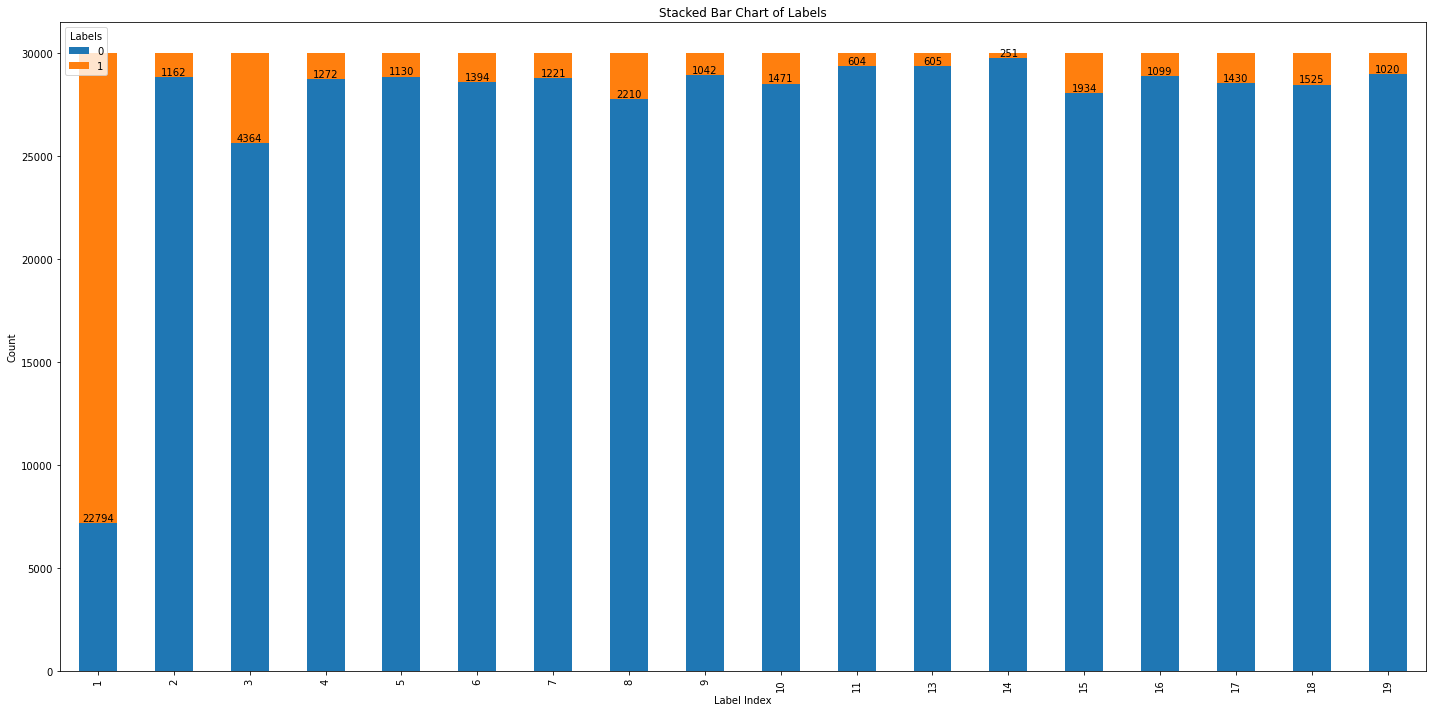

In [13]:
counters = [Counter(train["Labels" + str(i)])for i in range(1,20) if i != 12]

# Separate values for label 0 and 1 from each Counter
zeros = [c[0] for c in counters]
ones = [c[1] for c in counters]

# Create a list of indices (starting from 1)
indices = [i for i in range(1, 20) if i != 12]

# Create a DataFrame for the stacked bar chart
df = pd.DataFrame({'0': zeros, '1': ones}, index=indices)


# Draw a stacked bar chart
ax = df.plot(kind='bar', stacked=True, figsize=(20, 10))

# Extract the count of '1' labels to list for labeling on the chart
ones_count = [c[1] for c in counters]
# Label each bar with the count of '1' labels
for i, count in enumerate(ones_count):
    ax.text(i, train.shape[0] - count, str(count), ha='center', va='bottom', color='black')
    


# Add title and labels
plt.title('Stacked Bar Chart of Labels')
plt.xlabel('Label Index')
plt.ylabel('Count')
plt.legend(title='Labels')

# Display the graph
plt.tight_layout()
plt.show()

# NLP - Captions

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import pandas as pd

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatized_tokens(text):
    # Split text into tokens
    tokens = nltk.word_tokenize(text)
    # Convert to lowercase, remove stopwords, and extract lemmas
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words and token.isalpha()]
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haley\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\haley\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# #!pip install --user --upgrade pillow wordcloud
# !pip uninstall Pillow
# !pip install Pillow==8.1.0


In [15]:
import nltk
nltk.download('punkt')
from wordcloud import WordCloud
import PIL
print(PIL.__version__)


10.3.0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\haley\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 1 ####################################
man         0.048879
woman       0.031621
people      0.031533
standing    0.029443
sitting     0.026179
holding     0.025571
person      0.023061
riding      0.023037
next        0.020702
two         0.020412
dtype: float64


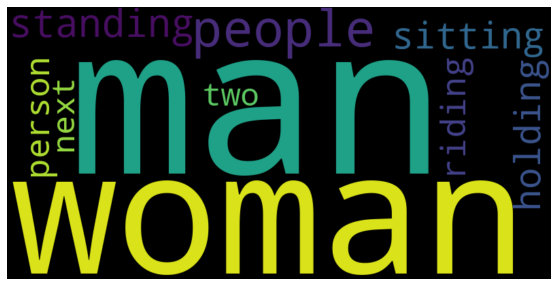

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 2 ####################################
bike       0.059378
street     0.058381
man        0.051849
riding     0.045433
bicycle    0.042363
people     0.039039
next       0.033336
parked     0.030907
woman      0.029705
city       0.026425
dtype: float64


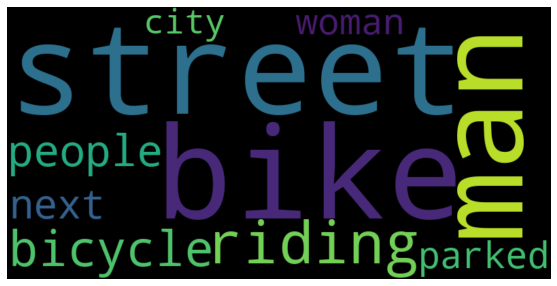

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 3 ####################################
street     0.057800
car        0.038582
bus        0.032922
man        0.032133
people     0.028516
city       0.026935
next       0.026844
sitting    0.025525
sign       0.024818
parked     0.024131
dtype: float64


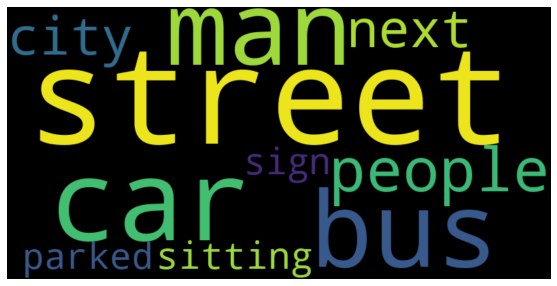

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 4 ####################################
motorcycle    0.094428
man           0.056907
parked        0.055397
riding        0.054156
street        0.053453
bike          0.035221
next          0.034591
people        0.034446
sitting       0.033307
road          0.032797
dtype: float64


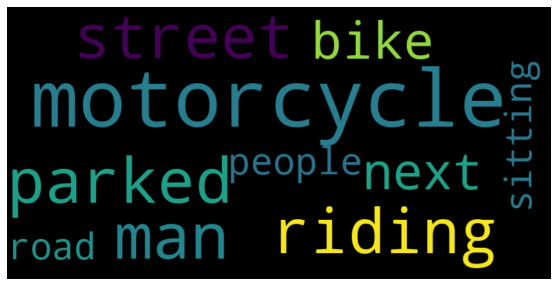

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 5 ####################################
airplane    0.084362
plane       0.074859
flying      0.068266
large       0.060723
sky         0.059126
runway      0.058684
airport     0.056794
sitting     0.052672
jet         0.052019
blue        0.038652
dtype: float64


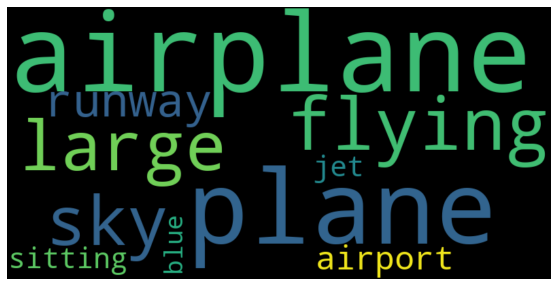

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 6 ####################################
bus         0.104156
street      0.078050
double      0.045226
city        0.044336
red         0.044326
driving     0.043841
decker      0.042751
parked      0.041692
next        0.036928
building    0.033271
dtype: float64


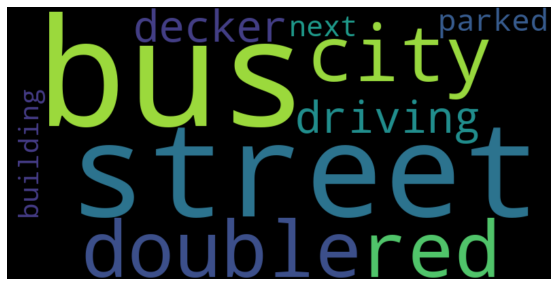

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 7 ####################################
train        0.133000
track        0.083300
station      0.058091
traveling    0.050476
next         0.039105
yellow       0.030232
parked       0.028406
car          0.028312
red          0.027883
sitting      0.027112
dtype: float64


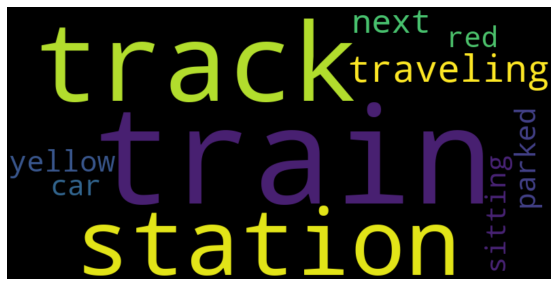

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 8 ####################################
truck      0.058600
street     0.050518
parked     0.037414
car        0.029792
sitting    0.029605
next       0.028926
large      0.026823
people     0.025944
man        0.025714
bus        0.025013
dtype: float64


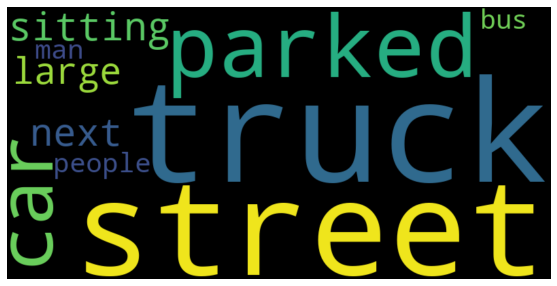

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 9 ####################################
boat       0.091933
water      0.066155
people     0.042350
sitting    0.037071
man        0.036292
beach      0.032502
small      0.032466
next       0.031466
large      0.031138
river      0.027623
dtype: float64


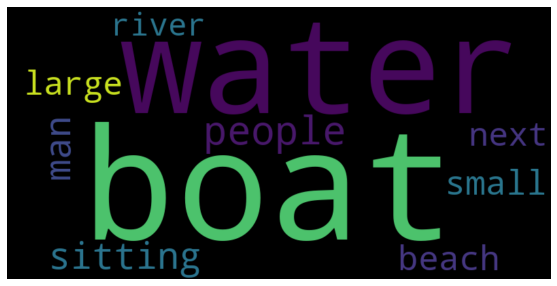

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 10 ####################################
street      0.085319
light       0.060385
traffic     0.056262
sign        0.043956
city        0.041926
car         0.038683
train       0.033992
bus         0.033442
building    0.033402
people      0.032721
dtype: float64


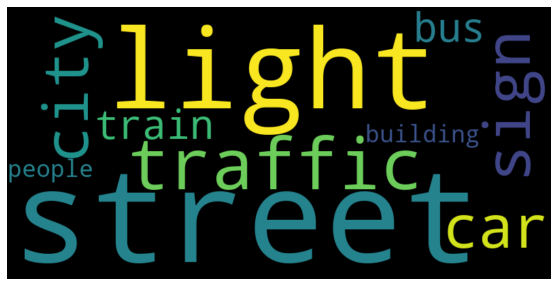

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 11 ####################################
fire        0.098729
hydrant     0.098060
street      0.061136
sitting     0.053944
red         0.052405
next        0.040420
yellow      0.037185
sidewalk    0.035872
side        0.033658
road        0.028617
dtype: float64


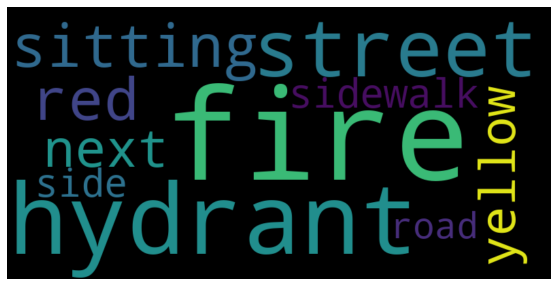

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 13 ####################################
sign        0.122013
stop        0.097779
street      0.076067
red         0.056461
sitting     0.033105
next        0.032260
pole        0.031556
building    0.029703
road        0.027859
side        0.026275
dtype: float64


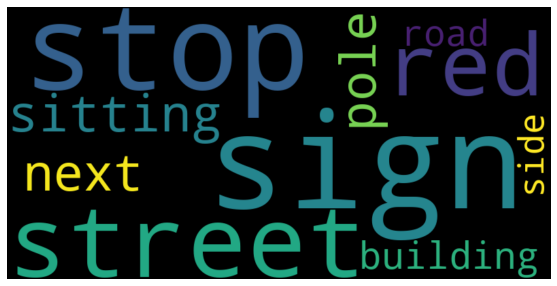

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 14 ####################################
parking     0.108612
meter       0.104839
street      0.074544
next        0.060007
sitting     0.052851
car         0.049037
parked      0.041165
two         0.035144
sidewalk    0.034231
side        0.033733
dtype: float64


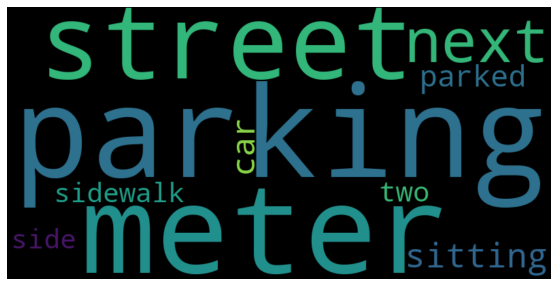

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 15 ####################################
bench       0.065340
sitting     0.053301
man         0.044335
woman       0.031982
people      0.029254
park        0.028108
baseball    0.027198
next        0.026705
wooden      0.025384
top         0.022473
dtype: float64


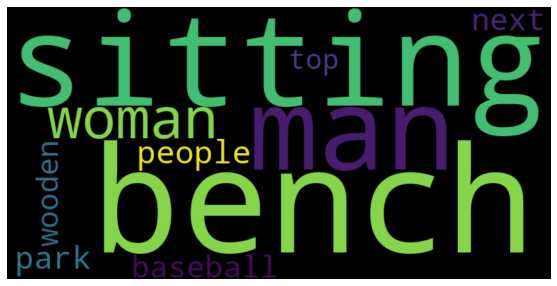

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 16 ####################################
bird        0.081850
standing    0.041321
sitting     0.040826
water       0.037517
top         0.033231
tree        0.030851
next        0.029185
small       0.028491
flying      0.027633
large       0.027083
dtype: float64


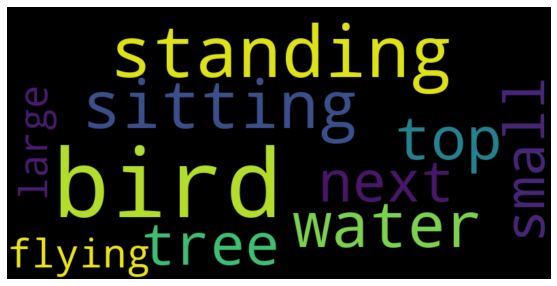

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 17 ####################################
cat         0.099863
sitting     0.059034
laying      0.054998
top         0.048428
black       0.041821
white       0.040218
bed         0.034474
next        0.032704
computer    0.028556
laptop      0.027979
dtype: float64


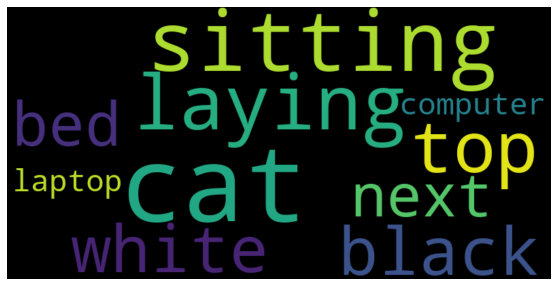

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 18 ####################################
dog         0.093685
sitting     0.044037
laying      0.035163
next        0.034337
man         0.033360
white       0.031706
frisbee     0.030764
brown       0.030534
black       0.028742
standing    0.027138
dtype: float64


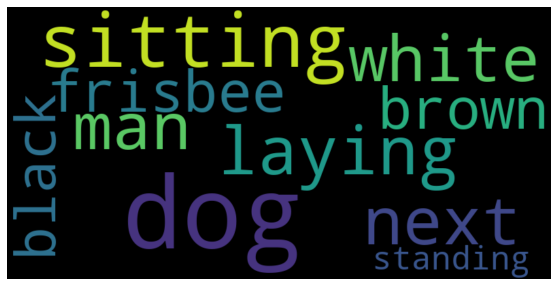

C:\Users\haley\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


################################### 19 ####################################
horse       0.101865
riding      0.055486
standing    0.047332
man         0.042927
field       0.041651
people      0.038540
brown       0.038329
two         0.037616
next        0.034025
woman       0.029883
dtype: float64


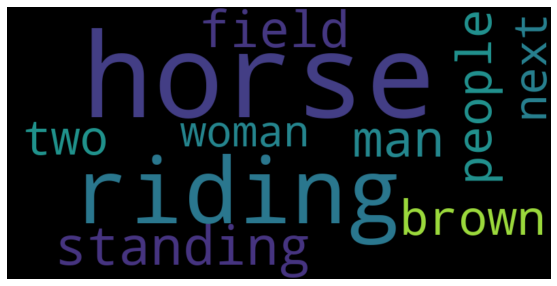

In [16]:
for i in range(1,20):
    if i != 12:
        documents = train[(train["Labels" + str(i)] == 1)]["Caption"].values.tolist()
        # Initialize the TF-IDF vectorizer
        vectorizer = TfidfVectorizer(tokenizer=lemmatized_tokens)

        # Compute the TF-IDF matrix for the document set
        tfidf_matrix = vectorizer.fit_transform(documents)

        # Extract each word and its corresponding index
        feature_names = vectorizer.get_feature_names_out()

        # Convert each word's TF-IDF score to a DataFrame
        tfidf_scores = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

        # Calculate the average TF-IDF score for each word
        avg_scores = tfidf_scores.mean().sort_values(ascending=False)

        # Print the top 10 words
        top_10_words = avg_scores.head(10)
        print("###################################",i,"####################################")
        print(top_10_words)
        
        df = pd.DataFrame(top_10_words)
        df.columns = ["avg_scores"]

        # Calculate the importance of each word based on average TF-IDF scores
        word_weights = {word: score for word, score in zip(df.index, df["avg_scores"])}

        # Create a WordCloud object
        wordcloud = WordCloud(width=800, height=400, background_color='black')

        # Generate the WordCloud
        wordcloud.generate_from_frequencies(word_weights)

        # Visualize the WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Hide axes
        plt.show()


# Class 1 -> human
# Class 2 -> Bicycle
# Class 3 -> Others
# Class 4 -> motocycle
# Class 5 -> airplane
# Class 6 -> bus
# Class 7 -> train
# Class 8 -> truck
# Class 9 -> boat
# Class 10 -> street
# Class 11 -> fire / fire related materials
# Class 13 -> sign (stopsign related)
# Class 14 -> parking
# Class 15 -> bench
# Class 16 -> bird
# Class 17 -> cat
# Class 18 -> dog
# Class 19 -> horse